In [310]:
import torch
import math

from torch import nn
from matplotlib import pyplot as plt
from pathlib import Path

In [311]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Linear Regression

## Data Preparing

In [312]:
# searched parameters
weight = -0.012
bias = 0.005

x = torch.arange(start=0, end=1, step=0.01, device=DEVICE).unsqueeze(dim=1)
y = x * weight + bias

x[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]], device='cuda:0'),
 tensor([[0.0050],
         [0.0049],
         [0.0048],
         [0.0046],
         [0.0045]], device='cuda:0'))

In [313]:
split_factor = math.ceil(len(x) * 0.8)

x_train, x_test, y_train, y_test = x[:split_factor], x[split_factor:], y[:split_factor], y[split_factor:]

x_train.shape, x_test.shape

(torch.Size([80, 1]), torch.Size([20, 1]))

## Plotting Functions

In [314]:
def plot_prediction(
    x_train,
    y_train,
    x_test,
    y_test,
    prediction=None,
    title=None):

  plt.figure(figsize=(10,7))

  # plot train data
  plt.scatter(x=x_train, y=y_train, s=4, marker="*", c='r')

  # plot test data
  plt.scatter(x=x_test, y=y_test, s=4, marker="+", c='g')

  if prediction is not None:
    # plot prediction
    plt.scatter(x=x_test, y=prediction, s=4, marker="X", c='b')

  if title is not None:
    plt.title(title)

  plt.legend()

In [315]:
def plot_loss(loss_data):
  plt.figure(figsize=(10,7))

  loss = []
  epoch = []

  for i in loss_data:
    with torch.inference_mode():
      loss.append(i["loss"].cpu())
      epoch.append(i["e"])

  plt.plot(epoch,loss)
  # print((epoch))
  # print((loss))

## Model Building

In [316]:
class LinearRegressionModel(nn.Module):

  def __init__(
      self,
      random_seed=None,
      loss_fn=None,
      optimizer=None
  ):
    super().__init__()

    if random_seed is not None:
      torch.manual_seed(random_seed)

    if(loss_fn is None):
      self.loss_fn = nn.L1Loss
    else:
      self.loss_fn = loss_fn

    if(optimizer is None):
      self.optimizer = torch.optim.SGD
    else:
      self.optimizer = optimizer

    self.layer1 = nn.Linear(in_features=1, out_features=1, device=DEVICE)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer1(x)

  def train(
      self,
      x:torch.Tensor,
      y:torch.Tensor,
      epochs=100,
      lr=0.01,
      verbose=False,
      verbose_every=None,
      track_loss=False
  ):
    loss_data = []

    loss_fn = self.loss_fn()
    optimizer = self.optimizer(params=self.parameters(), lr=lr)

    for epoch in range(epochs):
      y_pred = self.forward(x)

      loss = loss_fn(y_pred, y_train)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if track_loss:
        loss_data.append({
            "loss": loss,
            "e": epoch
        })

      if verbose:
        if epoch % (epochs-1) == 0 and epoch != 0:
          print("============== Last Epoch ==============")
          print(f"loss  : {loss}")
          print(f"params: {self.state_dict()}\n")
          continue

        if verbose_every is None:
          if epoch % (math.ceil(epochs*0.1)) == 0:
            print(f"loss  : {loss}")
            print(f"params: {self.state_dict()}\n")
        elif epoch % verbose_every == 0:
          print(f"loss  : {loss}")
          print(f"params: {self.state_dict()}\n")

    return loss_data

  def predict(self, x:torch.Tensor,):
    return self.forward(x)

In [317]:
RAND_SEED = 614

## Training Model

In [318]:
linreg_model_0 = LinearRegressionModel(random_seed=RAND_SEED)
loss_data = linreg_model_0.train(x_train, y_train, epochs=1000, lr=0.001, verbose=True, track_loss=True)

loss  : 0.051305998116731644
params: OrderedDict([('layer1.weight', tensor([[-0.0075]], device='cuda:0')), ('layer1.bias', tensor([-0.0469], device='cuda:0'))])

loss  : 0.0023016331251710653
params: OrderedDict([('layer1.weight', tensor([[-0.0007]], device='cuda:0')), ('layer1.bias', tensor([0.0002], device='cuda:0'))])

loss  : 0.00026921293465420604
params: OrderedDict([('layer1.weight', tensor([[-0.0111]], device='cuda:0')), ('layer1.bias', tensor([0.0055], device='cuda:0'))])

loss  : 0.00026921293465420604
params: OrderedDict([('layer1.weight', tensor([[-0.0111]], device='cuda:0')), ('layer1.bias', tensor([0.0055], device='cuda:0'))])

loss  : 0.00026921293465420604
params: OrderedDict([('layer1.weight', tensor([[-0.0111]], device='cuda:0')), ('layer1.bias', tensor([0.0055], device='cuda:0'))])

loss  : 0.00026921293465420604
params: OrderedDict([('layer1.weight', tensor([[-0.0111]], device='cuda:0')), ('layer1.bias', tensor([0.0055], device='cuda:0'))])

loss  : 0.00026921293465

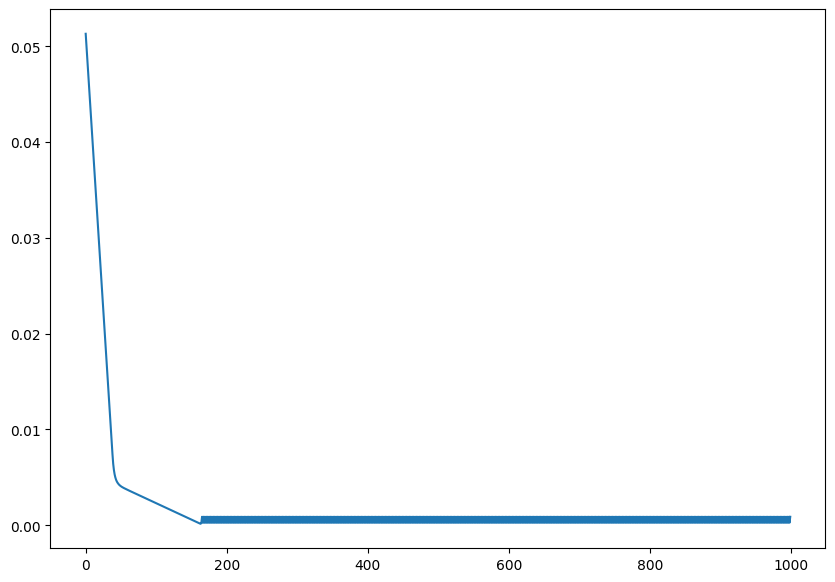

In [319]:
plot_loss(loss_data)

## Evaluating Model

In [320]:
y_pred = linreg_model_0.predict(x_test)
y_pred[:5], y_test[:5]

(tensor([[-0.0047],
         [-0.0048],
         [-0.0049],
         [-0.0050],
         [-0.0051]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[-0.0046],
         [-0.0047],
         [-0.0048],
         [-0.0050],
         [-0.0051]], device='cuda:0'))

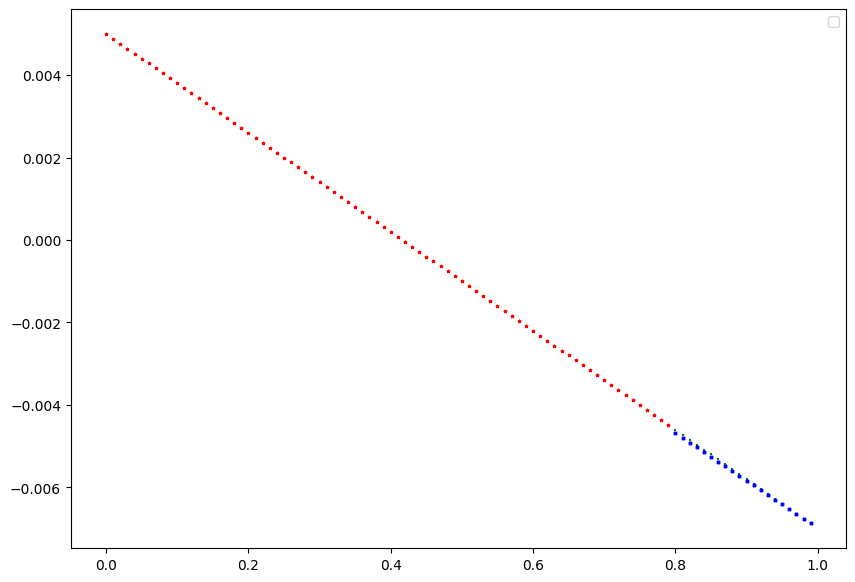

In [321]:
with torch.inference_mode():
  plot_prediction(x_train.cpu(),y_train.cpu(),x_test.cpu(),y_test.cpu(),y_pred.cpu())

## Train & Evaluate with Difference Loss Function & Optimizer

In [322]:
linreg_model_1 = LinearRegressionModel(random_seed=RAND_SEED, loss_fn=nn.MSELoss, optimizer=torch.optim.Adam)
loss_data = linreg_model_1.train(x_train, y_train, epochs=1000, lr=0.001, verbose=True, track_loss=True)

loss  : 0.002633205382153392
params: OrderedDict([('layer1.weight', tensor([[-0.0069]], device='cuda:0')), ('layer1.bias', tensor([-0.0469], device='cuda:0'))])

loss  : 4.8851212341105565e-05
params: OrderedDict([('layer1.weight', tensor([[0.0175]], device='cuda:0')), ('layer1.bias', tensor([-0.0080], device='cuda:0'))])

loss  : 1.2239249372214545e-05
params: OrderedDict([('layer1.weight', tensor([[0.0028]], device='cuda:0')), ('layer1.bias', tensor([-0.0015], device='cuda:0'))])

loss  : 1.8691252989810891e-06
params: OrderedDict([('layer1.weight', tensor([[-0.0062]], device='cuda:0')), ('layer1.bias', tensor([0.0025], device='cuda:0'))])

loss  : 1.804145313144545e-07
params: OrderedDict([('layer1.weight', tensor([[-0.0102]], device='cuda:0')), ('layer1.bias', tensor([0.0042], device='cuda:0'))])

loss  : 1.1085764306528745e-08
params: OrderedDict([('layer1.weight', tensor([[-0.0116]], device='cuda:0')), ('layer1.bias', tensor([0.0048], device='cuda:0'))])

loss  : 4.29870777862717

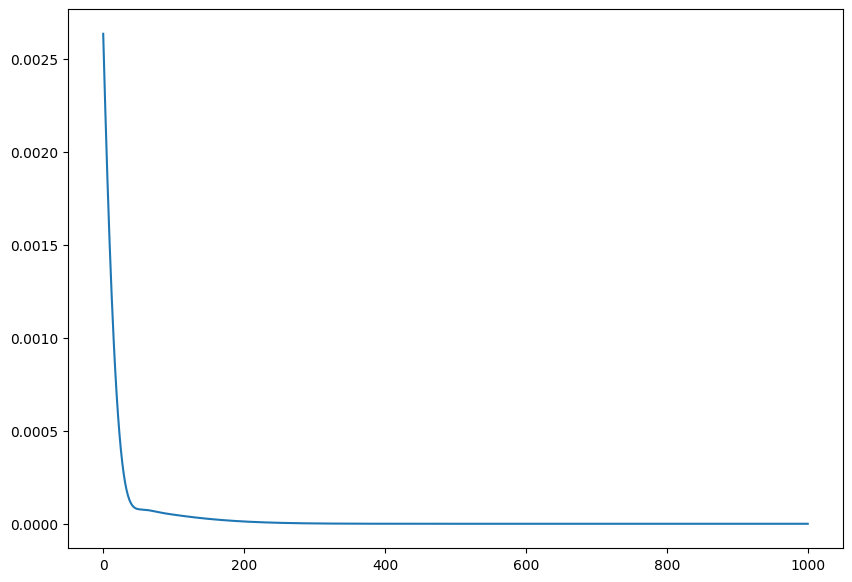

In [323]:
plot_loss(loss_data)

In [324]:
y_pred = linreg_model_0.predict(x_test)
y_pred[:5], y_test[:5]

(tensor([[-0.0047],
         [-0.0048],
         [-0.0049],
         [-0.0050],
         [-0.0051]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[-0.0046],
         [-0.0047],
         [-0.0048],
         [-0.0050],
         [-0.0051]], device='cuda:0'))

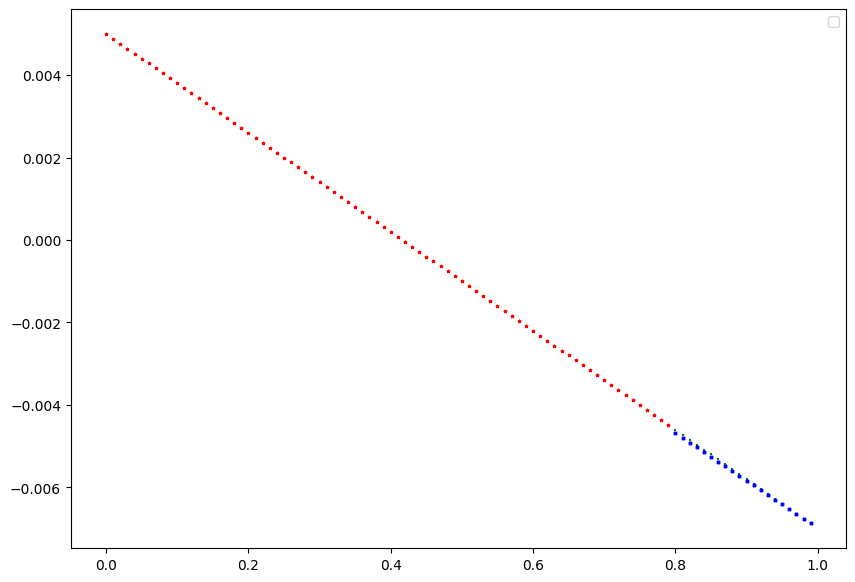

In [325]:
with torch.inference_mode():
  plot_prediction(x_train.cpu(),y_train.cpu(),x_test.cpu(),y_test.cpu(),y_pred.cpu())

In [326]:
linreg_model_0.state_dict(), linreg_model_1.state_dict(), weight, bias

(OrderedDict([('layer1.weight', tensor([[-0.0115]], device='cuda:0')),
              ('layer1.bias', tensor([0.0045], device='cuda:0'))]),
 OrderedDict([('layer1.weight', tensor([[-0.0120]], device='cuda:0')),
              ('layer1.bias', tensor([0.0050], device='cuda:0'))]),
 -0.012,
 0.005)